In [6]:

from src.data.dataset_reader import DatasetReader
from pathlib import Path
import pandas as pd
pd.set_option('display.max_columns', None)
%load_ext autoreload
%autoreload 2
# ignore warnings
import warnings
warnings.filterwarnings('ignore')
data_folder = Path("../data/raw").resolve()

amazon = DatasetReader(data_folder).get_data_csv('Amazon_Sale_Report.csv')



In [59]:
amazon.head()

,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,Size,ASIN,Courier Status,Qty,currency,price,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,0,405-8078784-5731545,2022-04-30,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,S,B09KXVBD7Z,NaN,0,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,2022-04-30,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,3XL,B09K3WFS32,Shipped,1,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
2,2,404-0687676-7273146,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,XL,B07WV4JV4D,Shipped,1,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN
3,3,403-9615377-8133951,2022-04-30,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,L,B099NRCT7B,NaN,0,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NaN,False,Easy Ship,NaN
4,4,407-1069790-7240320,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,3XL,B098714BZP,Shipped,1,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NaN,False,NaN,NaN


In [7]:
from src.data.feature_engineering import FeatureEngineeringProcess
fep = FeatureEngineeringProcess()


In [8]:

amazon['Date'] = pd.to_datetime(amazon['Date'])
amazon['ship-postal-code'] = amazon['ship-postal-code'].astype('object')
amazon.rename(columns={'Amount': 'price'}, inplace=True)
amazon_beta =  amazon[['Order ID','Date', 'SKU', 'Qty', 'price']]

In [13]:
from src.data.eda import Eda
eda = Eda(    
)

eda.missing_values_table(amazon_beta)

The selected dataframe has 6 columns and 0 columns with missing values.


,Missing Values,% of Total Values


In [9]:
# impute price missing values with the mean
amazon_beta['price'].fillna(amazon_beta['price'].mean(), inplace=True)

In [10]:

# Create a column called "sales" that is the count of the "Order ID" grouped by "SKU" and "Date" and price in the amazon_beta dataset
amazon_beta['sales'] = amazon_beta.groupby(['SKU', 'Date', 'price'])['Order ID'].transform('count')
amazon_beta.sort_values(by=['SKU', 'Date'], ascending=True, inplace=True)

In [11]:
amazon_beta_fe1 = fep.price_sales_correlation_features_updated(amazon_beta, 10, [(-5.0, 1.0), (-3.0, 1.0), (-2.0, 1.0), (1.0, 1.0), (-1.0, 0.5), (-1.0, 0.33)])


In [14]:
eda.missing_values_table(amazon_beta_fe1)


The selected dataframe has 12 columns and 6 columns with missing values.


,Missing Values,% of Total Values
f_corr_-5.0_1.0,57436,44.5
f_corr_-3.0_1.0,57436,44.5
f_corr_-2.0_1.0,57436,44.5
f_corr_-1.0_0.5,57436,44.5
f_corr_-1.0_0.33,57436,44.5
f_corr_1.0_1.0,43722,33.9


In [15]:
amazon_beta_fe2 = fep.normalize_features(amazon_beta_fe1, [5, 10, 15], 28)

In [16]:
# check for infs
import numpy as np
amazon_beta_fe2[amazon_beta_fe2 == np.inf].count()

Order ID                            0
Date                                0
SKU                                 0
Qty                                 0
price                               0
sales                               0
f_corr_-5.0_1.0                     0
f_corr_-3.0_1.0                     0
f_corr_-2.0_1.0                     0
f_corr_1.0_1.0                      0
f_corr_-1.0_0.5                     0
f_corr_-1.0_0.33                    0
normalized_log_avg_price_5_days     0
normalized_log_avg_sales_5_days     0
normalized_std_price_5_days         0
normalized_std_sales_5_days         0
normalized_log_avg_price_10_days    0
normalized_log_avg_sales_10_days    0
normalized_std_price_10_days        0
normalized_std_sales_10_days        0
normalized_log_avg_price_15_days    0
normalized_log_avg_sales_15_days    0
normalized_std_price_15_days        0
normalized_std_sales_15_days        0
dtype: int64

In [17]:
amazon_beta_fe3, insuficient_data = fep.filter_stability_periods(amazon_beta_fe2, 7, 0.04)

In [18]:

eda.missing_values_table(amazon_beta_fe3)

The selected dataframe has 24 columns and 18 columns with missing values.


,Missing Values,% of Total Values
f_corr_-5.0_1.0,48962,67.4
f_corr_-2.0_1.0,48962,67.4
f_corr_-1.0_0.5,48962,67.4
f_corr_-1.0_0.33,48962,67.4
f_corr_-3.0_1.0,48962,67.4
normalized_log_avg_sales_15_days,46694,64.3
normalized_log_avg_price_15_days,46694,64.3
normalized_log_avg_price_10_days,44376,61.1
normalized_log_avg_sales_10_days,44376,61.1
normalized_std_price_15_days,43795,60.3


Features to drop: ['f_corr_-3.0_1.0', 'f_corr_-2.0_1.0', 'f_corr_-1.0_0.5', 'f_corr_-1.0_0.33']


<Axes: >

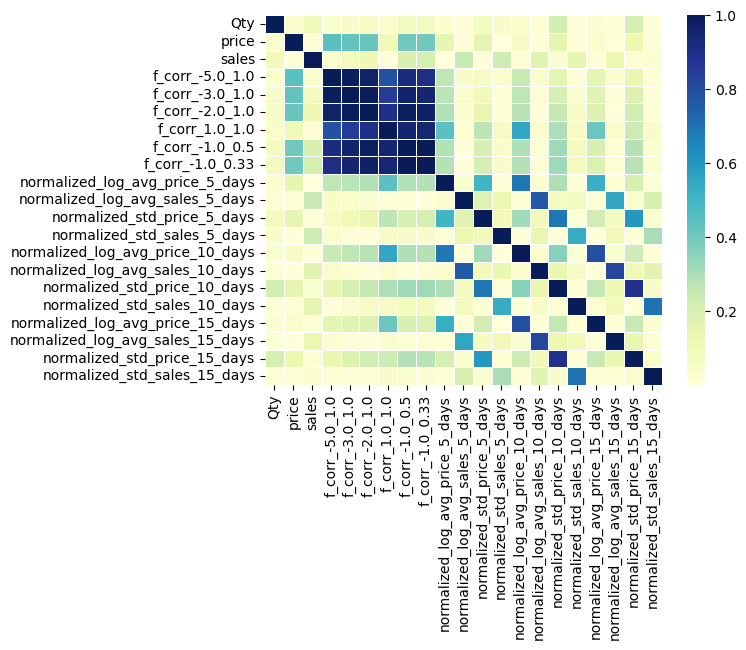

In [19]:
import seaborn as sns
# Create a correlation matrix to check for multicollinearity
corr_matrix = amazon_beta_fe3.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(f"Features to drop: {to_drop}")
# Plot the heatmap, make the plot readeble and annotate the values

sns.heatmap(corr_matrix, annot=False, cmap="YlGnBu", fmt='.2f', linewidths=.5, annot_kws={"size": 7})

# Drop features
#amazon_beta_fe3.drop(to_drop, axis=1, inplace=True)


In [20]:
amazon_beta_train= fep.datetime_transform(amazon_beta_fe3, 'Date',['day_of_the_year'])

In [21]:
# Drop Order Id, price_variation, insufficient_data
amazon_beta_train.drop(columns=['Order ID'], inplace=True)

In [22]:
# print min and max dates of amazon_beta_train
print(f"Min date: {amazon_beta_train['Date'].min()}")   
print(f"Max date: {amazon_beta_train['Date'].max()}")

Min date: 2022-03-31 00:00:00
Max date: 2022-06-29 00:00:00


In [23]:
# drop multicolinear features
amazon_beta_train.drop(to_drop, axis=1, inplace=True)

In [24]:
# impute missing values with the 0
amazon_beta_train.fillna(0, inplace=True)

In [25]:
from src.data.data_splitter import DataSplitter


data_splitter = DataSplitter(amazon_beta_train, target_variable='sales', date_column='Date', train_months=1, val_months=1, test_weeks=1)

X_train, y_train, X_val, y_val, X_test, y_test = data_splitter.split_data()



Training data covers from 2022-03-31 00:00:00 to 2022-04-29 00:00:00
Validation data covers from 2022-04-30 00:00:00 to 2022-06-22 00:00:00
Test data covers from 2022-06-23 00:00:00 to 2022-06-29 00:00:00


In [28]:
X_train_sku = X_train.copy()
X_val_sku = X_val.copy()
X_test_sku = X_test.copy()

In [ ]:
# Dump as pickel files X_train, y_train, X_val, y_val, X_test, y_test
import pickle
with open('../data/processed/X_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)
with open('../data/processed/y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)
with open('../data/processed/X_val.pkl', 'wb') as f:
    pickle.dump(X_val, f)
with open('../data/processed/y_val.pkl', 'wb') as f:
    pickle.dump(y_val, f)
with open('../data/processed/X_test.pkl', 'wb') as f:
    pickle.dump(X_test, f)
with open('../data/processed/y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)
    



In [4]:
# read pkl files from data/processed

import pandas as pd
X_train = pd.read_pickle('/Users/servandodavidtorresgarcia/Servando/Relu/Relu/data/processed/X_train.pkl')
y_train = pd.read_pickle('/Users/servandodavidtorresgarcia/Servando/Relu/Relu/data/processed/y_train.pkl')
X_val = pd.read_pickle('/Users/servandodavidtorresgarcia/Servando/Relu/Relu/data/processed/X_val.pkl')
y_val = pd.read_pickle('/Users/servandodavidtorresgarcia/Servando/Relu/Relu/data/processed/y_val.pkl')

In [29]:
X_train.head()

,SKU,Qty,price,f_corr_-5.0_1.0,f_corr_1.0_1.0,normalized_log_avg_price_5_days,normalized_log_avg_sales_5_days,normalized_std_price_5_days,normalized_std_sales_5_days,normalized_log_avg_price_10_days,normalized_log_avg_sales_10_days,normalized_std_price_10_days,normalized_std_sales_10_days,normalized_log_avg_price_15_days,normalized_log_avg_sales_15_days,normalized_std_price_15_days,normalized_std_sales_15_days,Date_day_of_the_year
44620,BL006-54BLACK,0,364.76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93
13992,BL006-54BLACK,1,383.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,112
48524,BL035-161GOLD,1,372.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91
48680,BL035-161GOLD,3,1116.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91
15569,BL035-161GOLD,1,372.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111


In [30]:
# Drop "SKU" column on X_train and X_val and X_test
X_train.drop(columns=['SKU'], inplace=True)
X_val.drop(columns=['SKU'], inplace=True)
X_test.drop(columns=['SKU'], inplace=True)

#TODO SEE THIS

In [31]:
from lightgbm import LGBMRegressor
import numpy as np
import matplotlib.pyplot as plt

lgb_params = {
    'n_jobs': 1,
    'max_depth': 4,
    'min_data_in_leaf': 10,
    'subsample': 0.9,
    'n_estimators': 80,
    'learning_rate': 0.1,
    'colsample_bytree': 0.9,
    'boosting_type': 'gbdt'
}
quantile_alphas = [0.1, 0.5, 0.9]

# Train a quantile lgbm model for every quantile_alpha
models = {}
for q in quantile_alphas:
    print(f'Fitting model for quantile {q}')
    models[q] = LGBMRegressor(objective='quantile', alpha=q, **lgb_params)
    models[q].fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  early_stopping_rounds=20)
    
# Compute quantile loss
def quantile_loss(y_true, y_pred, quantile_alpha):
    e = y_true - y_pred
    return np.maximum(quantile_alpha * e, (quantile_alpha - 1) * e)


Fitting model for quantile 0.1
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[1]	valid_0's quantile: 0.110376
[2]	valid_0's quantile: 0.110308
[3]	valid_0's quantile: 0.110248
[4]	valid_0's quantile: 0.110418
[5]	valid_0's quantile: 0.110364
[6]	valid_0's quantile: 0.110315
[7]	valid_0's quantile: 0.110455
[8]	valid_0's quantile: 0.110696
[9]	valid_0's quantile: 0.111003
[10]	valid_0's quantile: 0.110963
[11]	valid_0's quantile: 0.11093
[12]	valid_0's quantile: 0.110921
[13]	valid_0's quantile: 0.110921
[14]	valid_0's quantile: 0.110913
[15]	valid_0's quantile: 0.110905
[16]	valid_0's quantile: 0.110878
[17]	valid_0's quantile: 0.111268
[18]	valid_0's quantile: 0.111247
[19]	valid_0's quantile: 0.111247
[20]	valid_0's quantile: 0.111235
[21]	valid_0's quantile: 0.111224
[22]	valid_0's quantile: 0.111556
[23]	valid_0's quantile: 0.111549
Fitting model for quantile 0.5
[1]	valid_0's quantile: 0.534443
[2]	valid_0

In [32]:
# calculate the quantile loss for training and validation data

for q in quantile_alphas:
    model = models[q]
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    loss_train = quantile_loss(y_train, y_train_pred, q)
    loss_val = quantile_loss(y_val, y_val_pred, q)
    
    print(f"Quantile {q}: Training Loss = {loss_train.mean()}, Validation Loss = {loss_val.mean()}")


Quantile 0.1: Training Loss = 0.13643289007091872, Validation Loss = 0.11024775326797226
Quantile 0.5: Training Loss = 0.39754208386050827, Validation Loss = 0.4327084170702924
Quantile 0.9: Training Loss = 0.20800870258125373, Validation Loss = 0.3380929177194772


2. Interpret the Loss

Lower Loss is Better: The lower the loss, the better the model is performing for that particular quantile.

Differences Between Quantiles: Different quantiles might have different loss values. 
A lower quantile (e.g., 0.1) focuses on the lower tail of the distribution, whereas a higher quantile (e.g., 0.9) focuses on the upper tail. Depending on your data distribution, you might observe variations in performance across different quantiles.

3. Detect Overfitting and Underfitting

Overfitting: If the training loss is much lower than the validation loss, it might indicate that the model is memorizing the training data and not generalizing well to unseen data. This often occurs when the model is too complex relative to the amount and noise of the training data.

Underfitting: If both the training and validation loss are high, or if the validation loss is lower than the training loss, it might indicate that the model is too simple to capture the underlying pattern in the data. The model may need more complexity, or there may be issues with the data or feature

4. Considerations for Business Context

Tailoring to Business Needs: Depending on your specific business goals and the importance of different quantiles, you might want to focus on improving the performance of a specific quantile model. For example, if you're particularly concerned with the worst-case scenarios, you may prioritize the model for the lower quantile.

Fine-Tuning Hyperparameters: If you notice overfitting or underfitting, you can experiment with hyperparameters. For example, to reduce overfitting, you might increase the min_data_in_leaf, reduce the max_depth, or apply some form of regularization.

Quantile 0.1:

Training Loss: 0.13616
Validation Loss: 0.11030
Interpretation: Since the validation loss is lower than the training loss, it may indicate that the model is underfitting. Typically, underfitting would show higher validation loss compared to training loss, but this reversed pattern can also indicate underfitting, especially when the loss values are close. It might be worth experimenting with a more complex model or reducing regularization to see if that improves performance.

Quantile 0.5 (Median):

Training Loss: 0.39759
Validation Loss: 0.42580
Interpretation: The validation loss is slightly higher than the training loss, which is expected in a well-fitted model. This quantile seems to be well-calibrated, with a small difference between the training and validation losses.

Quantile 0.9:

Training Loss: 0.20936
Validation Loss: 0.33548
Interpretation: There is a larger difference between the training and validation losses, suggesting potential overfitting. The model performs well on the training data but has higher loss on the validation data. You might want to increase regularization or reduce the complexity of the model to make it generalize better to unseen data.

Summary:
Quantile 0.1: Possible underfitting. Consider increasing model complexity.
Quantile 0.5: Well-calibrated. Good balance between bias and variance.
Quantile 0.9: Possible overfitting. Consider reducing model complexity or increasing regularization

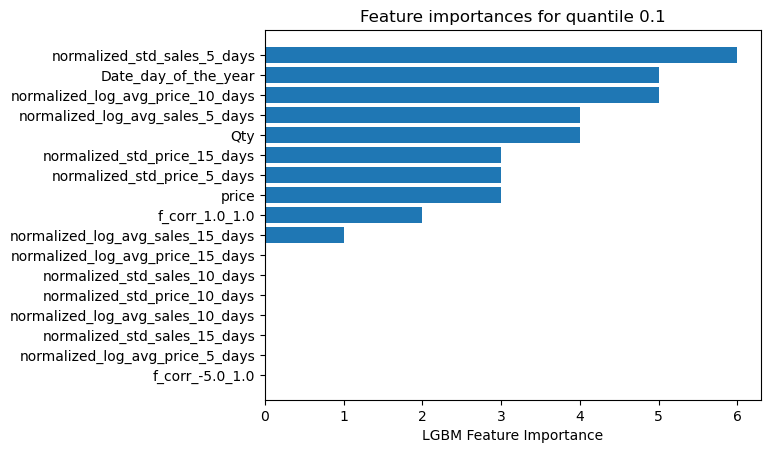

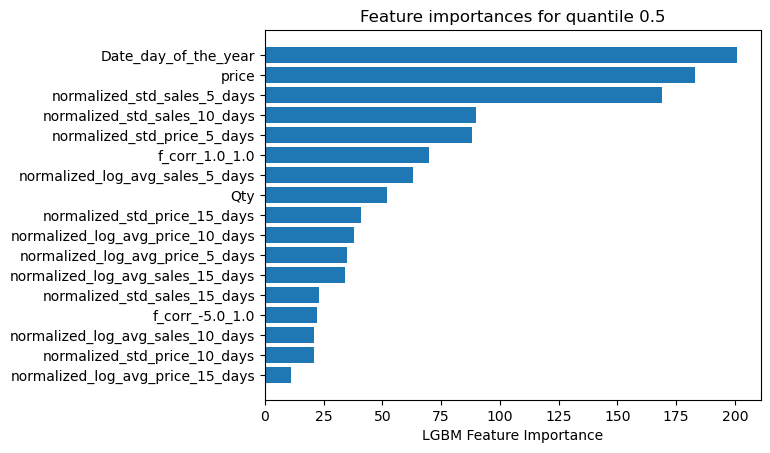

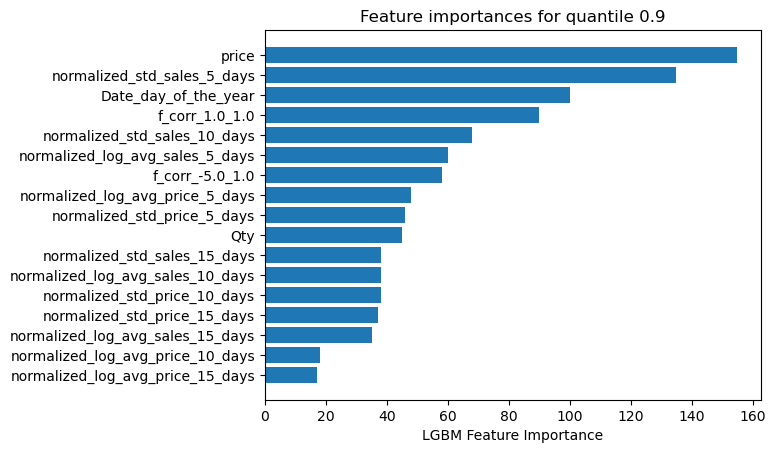

In [33]:

# Plot feature importance for every quantile_alpha
for q in quantile_alphas:
    plt.figure()
    plt.title(f'Feature importances for quantile {q}')
    # plot featur importances in a sorted order

    # get the indices of the sorted feature importances
    sorted_idx = models[q].feature_importances_.argsort()
    # plot the sorted feature importances
    plt.barh(X_train.columns[sorted_idx], models[q].feature_importances_[sorted_idx])
    plt.xlabel("LGBM Feature Importance")
    plt.show()

In [82]:
from typing import Dict
def predict_demand_curve(models: Dict, test_data:pd.DataFrame, base_price_feature: str='price'):

    sku_demand_curves = {}
    price_points_per_sku = {}
    demand_curve_pricing = {}

    price_multpliers = [0.85, 0.9, 0.95, 0.98, 1.0, 1.02, 1.05, 1.10, 1.15, 1.20]
    
    # Grouping test data by SKU
    grouped_test_data = test_data.groupby('SKU')
    
    # Performing inference for each SKU
    for sku, group_data in grouped_test_data:
        # Selecting one row from the group data
        sample_row = group_data.iloc[0].copy()

        # If SKU is present in the sample_row, remove it
        if 'SKU' in sample_row:
            sample_row.drop('SKU', inplace=True)
        
        # Setting the base price from data
        base_price = sample_row[base_price_feature]
        
        # Defining price points

        #base_price * 0.9: Reduces the base price by 10% (90% of base price).
        #base_price * 0.85: Reduces the base price by 15% (85% of base price).
        #base_price: Keeps the base price as it is.
        #base_price * 1.1: Increases the base price by 10% (110% of base price).
        #base_price * 1.15: Increases the base price by 15% (115% of base price).
        price_points = [base_price * factor for factor in price_multpliers]


        # storing price points per sku
        price_points_per_sku[sku] = price_points
        
        # Predicting sales for each price point
        demand_predictions = {}
        for q, model in models.items():
            demand_predictions[q] = []
            for price in price_points:
                sample_row[base_price_feature] = price
                prediction = model.predict([sample_row])
                demand_predictions[q].append(prediction[0])
        
        # Storing the demand curve for the SKU
        demand_curve = {q: list(zip(price_points, demand_predictions[q])) for q in quantile_alphas}
        sku_demand_curves[sku] = demand_predictions
        demand_curve_pricing[sku] = demand_curve

    return sku_demand_curves ,demand_curve_pricing ,  price_points_per_sku


In [83]:
sku_demand_curves, demand_curve_pricing, price_points_per_sku = predict_demand_curve(models, X_test_sku)

In [84]:
import plotly.express as px
import pandas as pd


def plot_demand_curve_for_sku(sku_demand_curves, price_points_per_sku, selected_sku):
    # Create the DataFrame properly
    data = []
    for sku, sku_demand_curve in sku_demand_curves.items():
        if sku == selected_sku:  # Only proceed if the SKU matches
            for q, demand_predictions in sku_demand_curve.items():
                for price, prediction in zip(price_points_per_sku[sku], demand_predictions):
                    data.append({'SKU': sku, 'Price Points': price, 'Predicted Sales': prediction, 'Quantile': f'Quantile {q}'})
    
    df = pd.DataFrame(data)
    
    # Create the Plotly figure for the selected SKU
    fig = px.line(df, x='Price Points', y='Predicted Sales', color='Quantile',
                  title=f'Demand Curve for SKU: {selected_sku}',
                  labels={'Price Points': 'Price Points', 'Predicted Sales': 'Predicted Sales'})
    fig.show()





In [85]:
plot_demand_curve_for_sku(sku_demand_curves, price_points_per_sku, selected_sku="BL035-161GOLD")